Попытка инференса полного pipeline модели

In [1]:
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

import torch
from torchvision.transforms import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.models import resnet18

import pytorch_lightning as pl
from pytorch_metric_learning import distances, losses, reducers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.utils.inference import CustomKNN

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import Levenshtein

from inference_sdk import InferenceHTTPClient
import pytesseract
import easyocr

import json
import warnings
warnings.filterwarnings('ignore')

In [2]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.9 🚀 Python-3.12.3 torch-2.4.0 CPU (Apple M3 Pro)
Setup complete ✅ (11 CPUs, 18.0 GB RAM, 287.9/460.4 GB disk)


In [3]:
base_transform = transforms.Compose(
    [
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


1. YOLO logo detection

Делаем инференс примерного кадра видео:

In [6]:
yolo_weights_path = '/Users/chervonikov_alexey/Desktop/VK_Video_Intern/notebooks/yolo/yolo_weigths/best.pt'
image_path = '/Users/chervonikov_alexey/Desktop/VK Video Intern/notebooks/figures/gant.png'

def logo_detection(yolo_weights_path:str = yolo_weights_path, 
				conf_threshold:int = 0.15, 
				plot_results:bool = False, 
				image_path:str = image_path):
	'''
	Функция получения результатов детекции логотипов
	
	Параметры:
	-yolo_weights_path: путь к сохранённым весами модели YOLO (str, default: yolo_weights_path)
	-conf_threshold: порог уверенности детекции (int, default: 0.25)
	-plot_results: флаг для построения изображений (bool, default: False)
	-image_path: путь к изображению (str, default: image_path)
	'''
	
	yolo_logo_detection = YOLO(yolo_weights_path)
	result = yolo_logo_detection(image_path, verbose = False)[0]
	initial_image = Image.open(image_path).copy()

	if plot_results:
		plt.imshow(initial_image)
		plt.show()

	initial_image = np.asarray(Image.open(image_path))
	
	annotator = Annotator(result.orig_img)
	boxes = result.boxes
	for box in boxes:
		b = box.xyxy[0]
		c = box.cls
		conf = box.conf
		if conf > conf_threshold:
			annotator.box_label(b, yolo_logo_detection.names[int(c)])
	
	img = annotator.result() 

	if plot_results:
		# print(f"Inference result:")
		# plt.imshow(img)
		# plt.show()
		plt.savefig(img)

	cropped_images = []
	if plot_results:
		print(f"Cropped results:")
	for i, box in enumerate(boxes):
		b = box.xyxy[0].cpu().numpy()
		# print(b)
		x_min, y_min, x_max, y_max = b[0], b[1], b[2], b[3]
		x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])
		cropped_image = initial_image[y_min:y_max, x_min:x_max]
		cropped_images.append(cropped_image)
		if plot_results:
			plt.imshow(cropped_image)
			plt.show()
	
	cropped_images.append(initial_image)
		

	return cropped_images


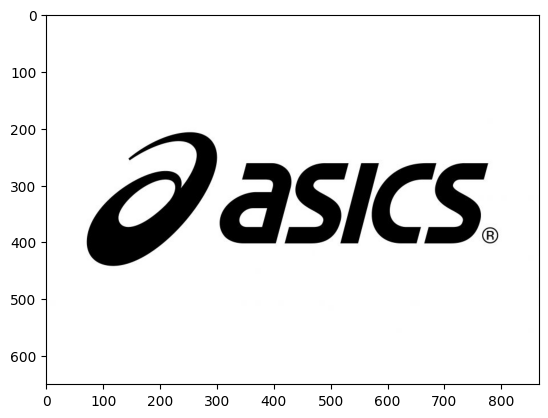

Inference result:


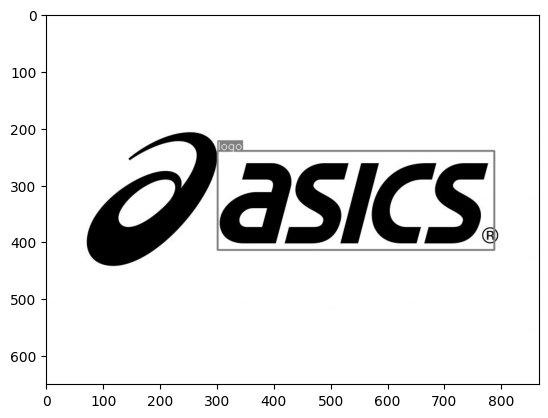

Cropped results:


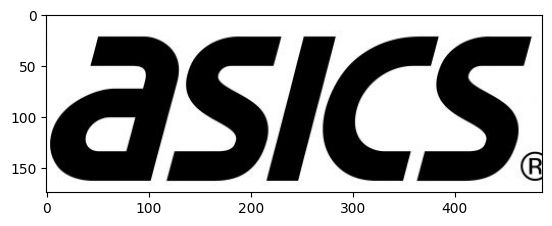

No. of detected logos: 2


In [7]:
cropped_images = logo_detection(plot_results=True, image_path='/Users/chervonikov_alexey/Desktop/VK_Video_Intern/notebooks/figures/asics1.jpg')
print(f"No. of detected logos: {len(cropped_images)}")

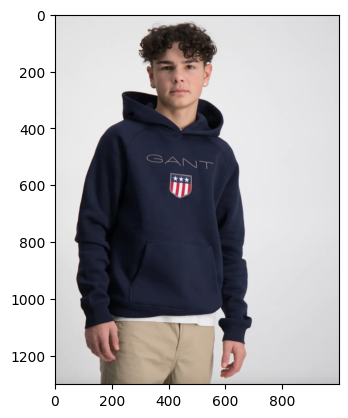

Inference result:


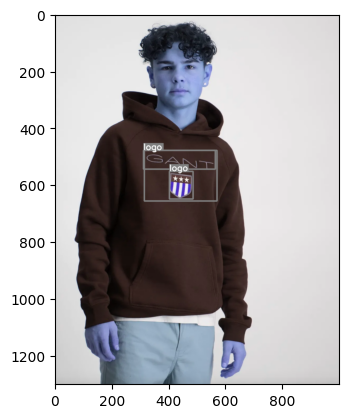

Cropped results:


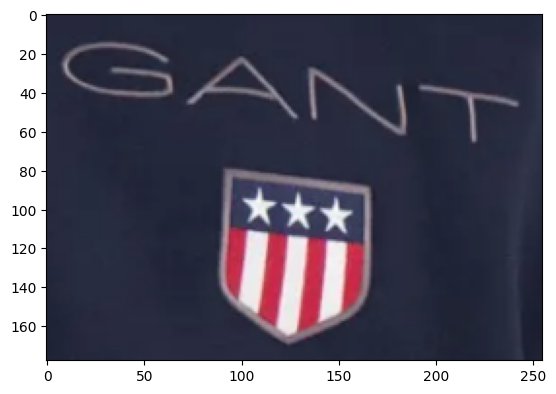

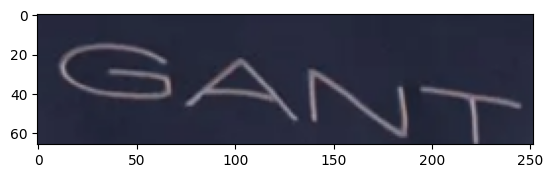

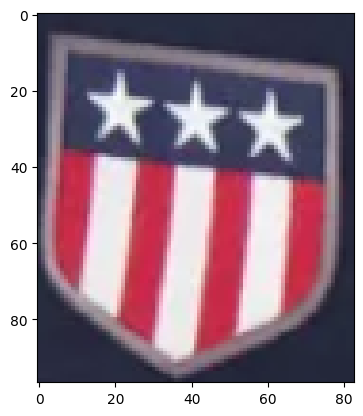

No. of detected logos: 4


In [139]:
cropped_images = logo_detection(plot_results=True)
print(f"No. of detected logos: {len(cropped_images)}")

Инференс для логотипа:

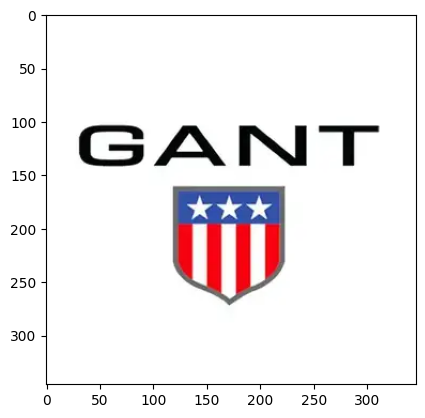

Inference result:


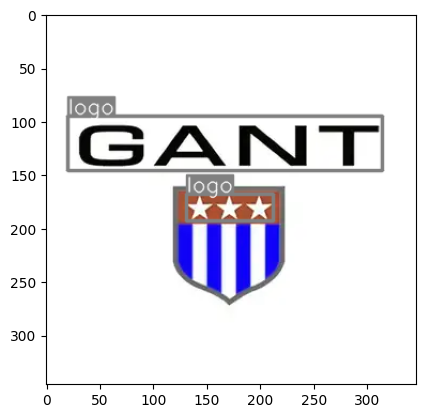

Cropped results:


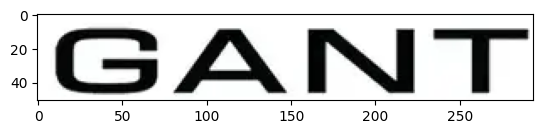

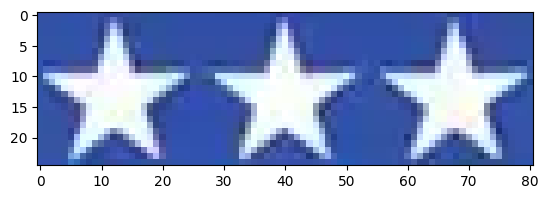

No. of detected logos: 3


In [140]:
cropped_images_logo = logo_detection(plot_results=True, 
                                    image_path = '/Users/chervonikov_alexey/Desktop/VK Video Intern/notebooks/figures/gant_logo.jpg')
print(f"No. of detected logos: {len(cropped_images_logo)}")

2. Text Detection:

Для каждого ```cropped_image``` получаем примерную оценку на наличие текста с использованием ```Roboflow API```

In [141]:
from inference_sdk import InferenceHTTPClient
API_KEY = 'gKkrveQc1gtDAoKcppQq'

def get_text_predictions(cropped_images, api_key):
	'''
	Функция предсказания текста по cropped результатам Object Detection

	Параметры:
	-cropped_images: массив полученных обрезанных изображений (default: cropped_images)
	-api_key: API_KEY roboflow.com
	'''

	CLIENT = InferenceHTTPClient(
		api_url="https://infer.roboflow.com",
		api_key=api_key
	)

	text_results = []

	for image in cropped_images:
		result = CLIENT.ocr_image(inference_input=image)  
		text_results.append(result)

	return text_results

text_results = get_text_predictions(cropped_images=cropped_images,
									api_key=API_KEY)
	

Результаты

Мы видим разные метрики, поэтому есть смысл исследовать разные модели и выбирать лучшую

In [142]:
API_KEY = 'gKkrveQc1gtDAoKcppQq'

def get_text_predictions(cropped_images, api_key):
	'''
	Функция предсказания текста по cropped результатам Object Detection

	Параметры:
	-cropped_images: массив полученных обрезанных изображений (default: cropped_images)
	-api_key: API_KEY roboflow.com
	'''

	CLIENT = InferenceHTTPClient(
		api_url="https://infer.roboflow.com",
		api_key=api_key
	)

	text_results = []
	reader = easyocr.Reader(['en'])

	for image in cropped_images:
		result_roboflow = CLIENT.ocr_image(inference_input=image)  
		result_tesseract = pytesseract.image_to_string(image)
		result_easyocr = reader.readtext(image)
		text_results.append(result_roboflow['result'])
		text_results.append(result_tesseract)

		for (bbox, text, prob) in result_easyocr:
			text_results.append(text)
		break

	return text_results

text_results = get_text_predictions(cropped_images=cropped_images,
									api_key=API_KEY)
	

In [143]:
print(text_results)

['', '', 'X*r', 'GANT']


In [144]:
text_results_logo = get_text_predictions(cropped_images=cropped_images_logo,
									api_key=API_KEY)

In [145]:
print(text_results_logo)

['', '', 'GANT']


Таким образом, можем прийти к метрике Левенштейна. Находя максимум (custom метрика), можем делать вывод о соответствии логотипов. Чем ближе - тем лучше!

In [146]:
def lev_metric(cropped_images_predicted, 
			cropped_images_logo):
	
	max_ = 0
	for pred in cropped_images_predicted:
		for logo in cropped_images_logo:
			pred_filtered = ''.join([char for char in pred if char.isalpha()])
			logo_filtered = ''.join([char for char in logo if char.isalpha()])
			distance = Levenshtein.distance(logo_filtered, pred_filtered)
			max_len = max(len(pred_filtered), len(logo_filtered)) 
			normalized_distance = distance / max_len if max_len != 0 else 1
			if 1 - normalized_distance > max_ and len(pred_filtered) != 0 and len(logo_filtered) != 0:
				max_ = 1 - normalized_distance

	return max_

lev_dist = lev_metric(text_results_logo, text_results)
print(f"Максимальная метрика Левенштейна (Custom Implementation): {lev_dist}")

Максимальная метрика Левенштейна (Custom Implementation): 1.0


Далее необходимо написать общую функцию для встраивания инференса с подсчетом метрик на основе текстовой информации, извлечённой из логотипов

In [147]:
API_KEY = 'gKkrveQc1gtDAoKcppQq'
yolo_weights_path = '/Users/chervonikov_alexey/Desktop/VK Video Intern/notebooks/yolo/yolo_weigths/best.pt'
image_path_ = '/Users/chervonikov_alexey/Desktop/VK Video Intern/notebooks/figures/gant.png'
logo_path = '/Users/chervonikov_alexey/Desktop/VK Video Intern/notebooks/figures/gant_logo.jpg'

def get_text_metric(logo_searched:str, 
					video_frame:str, 
					yolo_path:str,
					api_key:str):
	
	cropped_images = logo_detection(plot_results=False, yolo_weights_path=yolo_path,
									image_path = video_frame)
	
	cropped_images_logo = logo_detection(plot_results=False, yolo_weights_path=yolo_path,
									image_path = logo_searched)
	
	video_frame_text_pred = get_text_predictions(cropped_images=cropped_images,
									api_key=api_key)
	
	logo_text_pred = get_text_predictions(cropped_images=cropped_images_logo,
									api_key=api_key)
	
	lev_metric_res = lev_metric(video_frame_text_pred, logo_text_pred)

	return lev_metric_res

lev_metric_calc = get_text_metric(logo_searched=logo_path,
						   video_frame=image_path_, 
						   yolo_path=yolo_weights_path,
						   api_key=API_KEY)
	
print(f"Levenstein metric result {lev_metric_calc}")
	

Levenstein metric result 1.0


Далее необходимо организовать подсчет метрики косинусной близости

Класс модели

In [150]:
dict_path = '/Users/chervonikov_alexey/Desktop/VK Video Intern/notebooks/metric_learning/labels/idx2classname.json'

with open(dict_path, 'r') as json_file:
    idx2classname = json.load(json_file)
    
class modelArcFaceLoss(pl.LightningModule):

	'''
	Класс модели с функцией потерь ArcFaceLoss (наследует методы из pl.LightningModule)
	'''

	def __init__(
			self,
			model=resnet18(pretrained=True), # базовая модель resnet18
			embedding_size=128,
			distance_metric=distances.CosineSimilarity(),
			reducer=reducers.ThresholdReducer(low=0),
			loss_fn=losses.ArcFaceLoss,  # Вот она ArcFace из pytorch_metric_learning
			arcface_margin=0.5,  # margin гиперпараметр
			arcface_scale=64,  #scale гиперпараметр
			optimizer=Adam, 
			optimizer_params={'lr': 0.001, 'weight_decay': 0.0001},
			class_dict=idx2classname,
			min_lr=1e-5,
			step_size=8,
			gamma=0.5
			):
		
		'''
		Конуструктор объекта класс def __init__(self, ...)

		Парамеры:
		-model: Базовая модель (default: resnet18(pretrained = True))
		-embedding_size: Размер эмбеддингов после сверточных слоев для решения задачи Metric Learning (default = 128)
		-distance_metric: Метрика подсчета расстояния между объектами (default: CosineSimilarity())
		-reduce: Функция редукции потерь, которая используется для фильтрации значений loss на основе порогового значения.
		Например, ThresholdReducer(low=0) игнорирует все значения потерь ниже 0.
		Это может повысить устойчивость к шуму в данных (default: ThresholdReducer(low=0))
		-loss_fn: функция потерь (default: ArcFaceLoss)
		-arcface_margin: Смещение угла в формуле функции потерь (default: 0.5)
		-arcface_scale: Масшатабирующий параметр в формуле функции потерь (default: 64)
		-optimizer: оптимизатор (default: Adam)
		-optimizer_params: параметры оптимизатора
		-class_dict: словарь Dict label->idx2classname
		-min_lr: минимальный шаг сходимости (тот предел, до которого уменьшается lr в процессе обучения)
		-step_size: число эпох, через которое экпоненциально уменьшаем шаг сходимости
		-gamma: уменьшающий множитель 

		Инициализирует всё необходимое

		'''

		super(modelArcFaceLoss, self).__init__()

		# Модель и её параметры (Архитектура + Функция потерь + Оптимизатор)
		self.backbone = model,
		self.backbone = self.backbone[0]
		self.embedding_size = embedding_size
		self.backbone.fc = nn.Linear(self.backbone.fc.in_features, self.embedding_size)
		self.fc = nn.Linear(self.embedding_size, self.embedding_size)
		self.distance = distance_metric
		self.reducer = reducer
		self.arcface_margin = arcface_margin
		self.arcface_scale = arcface_scale
		self.loss_fn = loss_fn(
			num_classes=len(class_dict),
			embedding_size=self.embedding_size,
			margin=self.arcface_margin,
			scale=self.arcface_scale
		)

		self.optimizer_params = optimizer_params
		self.optimizer = optimizer(self.parameters(), **self.optimizer_params)
		self.class_dict = class_dict

		# Если мы хотим еще параллельно решать задачу классификации на основе привычной CrossEntropy
		self.classifier_head = nn.Sequential(
			nn.ReLU(),
			nn.Linear(in_features=self.embedding_size, out_features=len(self.class_dict))
		)
		self.classif_loss = torch.nn.CrossEntropyLoss()
		self.save_hyperparameters()
		self.gamma = gamma
		self.step_size = step_size
		self.scheduler = StepLR(self.optimizer, step_size=self.step_size, gamma=self.gamma)
		self.min_lr = min_lr

		# Эмбеддинги для подсчета метрик в конце валидации
		self.val_embeddings = []
		self.val_labels = []

	def forward(self, input_x):
		'''
		forward модели после подачи batch_size:

		Параметры:
		-self
		-input_x: входой пакет картинок

		Возвращает эмбеддинг картинки
		'''

		# Прогон через CNN
		cnn_output = self.backbone(input_x)
		# Прогон через линейные слои
		embedding = self.fc(cnn_output)
		return embedding

	def training_step(self, batch, batch_idx):
			'''
			Часть train логики: подаем батч, разбиваем на (images, labels)
			Возвращем loss, по которому будет считаться градиент
			'''

			images, labels = batch
			embeddings = self(images)

			# ArcFace loss
			loss_arcface = self.loss_fn(embeddings, labels)
			final_loss = loss_arcface

			self.log('train_loss', final_loss, sync_dist=True)
			return final_loss

	def on_train_start(self):
		self.train()

	def validation_step(self, batch, batch_idx):
			
			'''
			Логика на валидации: подаем батч, считаем loss на валидации и записываем в tensor_board
			И добавляем эмбеддинги и метки для подсчёта метрик
			'''

			images, labels = batch
			embeddings = self(images)

			loss_arcface = self.loss_fn(embeddings, labels)

			final_loss = loss_arcface
			self.log('validation_loss', final_loss, sync_dist=True)

			self.val_embeddings.append(embeddings)
			self.val_labels.append(labels)

	def on_validation_epoch_end(self):
			
			'''
			Логика в конце валидации: считает ключевую метрики на валидации, а именно precision@1:
            
			-precision@1
			-Обнуляет массивы эмбеддингов и меток в конце
			'''

			all_embeddings = torch.cat(self.val_embeddings)
			all_labels = torch.cat(self.val_labels)

			accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1, knn_func=CustomKNN(
				distances.CosineSimilarity(), batch_size=64))

			metrics = accuracy_calculator.get_accuracy(all_embeddings, all_labels)
			precision_at_1 = metrics["precision_at_1"]
			self.log('precision_at_1_epoch', precision_at_1, sync_dist=True)

			self.val_embeddings = []
			self.val_labels = []

	def on_validation_start(self):
			self.eval()

	def configure_optimizers(self):
		'''
		Объявление оптимизатора и его фичей
		'''
		
		return {
			'optimizer': self.optimizer,
			'lr_scheduler': {
				'scheduler': self.scheduler,
				'interval': 'epoch',
				'frequency': 1,
				'reduce_on_plateau': False,
				'monitor': 'validation_loss',
			}
		}

	def lr_scheduler_step(self, scheduler, metric):
		'''
		Обновление шага сходимости
		'''

		scheduler.step()
		self._adjust_learning_rate()

	def _adjust_learning_rate(self):
		'''
		Проверка достижения предела learning_rate (self.min_lr)
		'''
		
		for param_group in self.optimizer.param_groups:
			param_group['lr'] = max(param_group['lr'], self.min_lr)
		
		

Функция получения эмбеддингов изображений

In [156]:
def make_inference_model_arcface(image_info, 
								model_weights_path:str, 
								model):
	'''
	Функция для осуществления инференса
	
	Параметры:
	-image_path: путь к тестируемому изображению 
	-model_weights_path: путь к сохраненнымии весами (str)
	-model: класс модели
	'''

	if type(image_info) == str:
		image = Image.open(image_path).convert('RGB')
	else:
		image = Image.fromarray(image_info)
	image_tensor = base_transform(image)
	image_tensor = image_tensor.unsqueeze(0) 
	pl_model = model.load_from_checkpoint(model_weights_path)
	pl_model.eval()

	with torch.no_grad():
		output = pl_model(image_tensor).cpu()[0]
	
	return output


Функция для получения максимальной метрики близости

In [165]:
arcface_weights_path = '/Users/chervonikov_alexey/Desktop/VK Video Intern/notebooks/metric_learning/arcface_weights/best-precision-arcfaceloss-epoch=14-precision_at_1_epoch=0.95.ckpt'

def cosine_sim(cropped_images_predicted, 
			cropped_images_logo, 
			arcface_weights_path, 
			model):
	
	max_cos_sim = 0
	for pred in cropped_images_predicted:
		for logo in cropped_images_logo:
			first_output = make_inference_model_arcface(pred, arcface_weights_path, model)
			second_output = make_inference_model_arcface(logo, arcface_weights_path, model)
			cos_sim = F.cosine_similarity(first_output.unsqueeze(0), second_output.unsqueeze(0))[0]
			if cos_sim >= max_cos_sim:
				max_cos_sim = cos_sim
	return max_cos_sim

def get_cosine_similarity(logo_searched:str, 
					video_frame:str, 
					yolo_path:str):
    
	cropped_images = logo_detection(plot_results=False, yolo_weights_path=yolo_path,
									image_path = video_frame)
	
	cropped_images_logo = logo_detection(plot_results=False, yolo_weights_path=yolo_path,
									image_path = logo_searched)
	
	cos_sim = cosine_sim(cropped_images, 
					  	cropped_images_logo, 
					  	arcface_weights_path, 
						modelArcFaceLoss)
	
	return cos_sim

similarity = get_cosine_similarity(logo_searched=logo_path,
						   video_frame=image_path_, 
						   yolo_path=yolo_weights_path)

print(similarity)


tensor(0.6499)


У двух одинаковых близкая метрика

In [167]:
img_path = '/Users/chervonikov_alexey/Desktop/VK Video Intern/notebooks/figures/adidas_shop.jpg'

similarity = get_cosine_similarity(logo_searched=logo_path,
						   video_frame=img_path, 
						   yolo_path=yolo_weights_path)

print(similarity)

tensor(0.4934)


Уже ниже